In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
from src.pipeline import *
from src.utils import PropertyDict, print_conversation
from datasets.utils.logging import disable_progress_bar
import pandas as pd
from src.evaluation import evaluate_conversation
from src.train import Linear

In [7]:
hyperparameters = PropertyDict(
    seed=42,
    checkpoint_name="bert_tiny",
    model_name="bert_tiny",
    model_type="encoder_decoder",
    initialize_cross_attention=True,
    # yng_loss_weight=1.0,
    # rationale_loss_weight=1.0,
    # generative_loss_weight=1.0,
    yng_loss_weight=5.,
    rationale_loss_weight=3.,
    generative_loss_weight=1.,
    batch_size=8,
    val_batch_size=16,
    generate_batch_size=128,
    num_workers=0,
    num_epochs=3,
    optimizer_name="AdamW",
    # learning_rate=5e-3,
    learning_rate=2e-5,
    loss_learning_rate=1e-1,
    scheduler="linear",
    warmup_fraction=0.1,
    accumulation_steps=1,
    gradient_clip = 1.0,
    mixed_precision="fp16",
    checkpoint_interval=1000,
    log_interval=1000,
    cpu=False
)

In [4]:
with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
    config = wandb.config

    set_seed(config.seed)

    # Make the model
    tokenizer, model = make_model(config)

    # Make the data
    train_data = get_data("train", config).shuffle(42)
    # .select(range(1000))
    val_data = get_data("validation", config).shuffle(42)
    # .select(range(64))
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )

    # model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, metrics = make(config)
    print(model)

    tf_scheduler = Linear(1., 0.7, total_iters=len(train_dataloader)*config.num_epochs)
    train(
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        config,
        teacher_force_scheduler=tf_scheduler
    )

    results = evaluate(model, tokenizer, train_data, val_data, config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteo-periani. Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.
QAEncoderDecoderModel(
  (encoder): QAEncoder(
    (encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-1): 2 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
          

 12%|█▏        | 1001/8025 [01:59<9:58:32,  5.11s/it]

Iteration:   1000	train loss: 13.0747	val loss: 8.8147	lr: 0.000019


 25%|██▍       | 2001/8025 [04:01<8:33:15,  5.11s/it]

Iteration:   2000	train loss: 7.9149	val loss: 8.4364	lr: 0.000017


 37%|███▋      | 3001/8025 [06:02<7:05:12,  5.08s/it]

Iteration:   3000	train loss: 7.4832	val loss: 8.3853	lr: 0.000014


 50%|████▉     | 4001/8025 [08:01<5:36:33,  5.02s/it]

Iteration:   4000	train loss: 7.3497	val loss: 8.3004	lr: 0.000011


 62%|██████▏   | 5001/8025 [10:01<4:13:55,  5.04s/it]

Iteration:   5000	train loss: 7.2292	val loss: 8.1905	lr: 0.000008


 75%|███████▍  | 6001/8025 [11:59<2:48:06,  4.98s/it]

Iteration:   6000	train loss: 7.1819	val loss: 8.0969	lr: 0.000006


 87%|████████▋ | 7001/8025 [13:57<1:25:17,  5.00s/it]

Iteration:   7000	train loss: 7.1858	val loss: 8.0393	lr: 0.000003


100%|█████████▉| 8001/8025 [15:55<02:00,  5.04s/it]  

Iteration:   8000	train loss: 7.1346	val loss: 8.0223	lr: 0.000000


100%|██████████| 8025/8025 [16:10<00:00,  5.36it/s]

Iteration:   8025	train loss: 7.3519	val loss: nan	lr: 0.000000


100%|██████████| 8025/8025 [16:31<00:00,  8.10it/s]
Parameter 'function'=<function evaluate_tokenized_dataset.<locals>.<lambda> at 0x7fa16fc52fc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/85574 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


avg_generative_loss,█▂▁▁▁▁▁▁▁
avg_rationale_loss,█▅▃▂▂▁▁▁▁
avg_train_loss,█▂▁▁▁▁▁▁▁
avg_yng_loss,█▂▁▁▁▁▁▁▁
checkpoint_counter,▁▂▃▄▅▆▇█
generative_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▁▂▂▂▂▁▂▂▂▃▂▃▂▂
lr,▁▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
rationale_loss,████▇▇▇▆▅▄▅▅▆▅▅▆▅▄▄▄▄▅▅▂▅▆▇▅▃▆▃▃▄▃█▁▄▃▆▂
train_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁▂▂▂▃▂▃▂▂
val_generative_loss,█▅▅▄▃▂▁▁
val_loss,█▅▄▃▂▂▁▁


In [5]:
tokenizer, model = make_model(hyperparameters)
model.load_state_dict(torch.load("checkpoints/distil_roberta_42_nh_2.pt"))

set_size = 1000
train_set = get_data("train", hyperparameters).shuffle(42)
val_set = get_data("validation", hyperparameters).shuffle(42)
test_set = get_data("test", hyperparameters).shuffle(42)

if set_size is not None:
    train_set = train_set.select(range(set_size))
    val_set = val_set.select(range(set_size))
    test_set = test_set.select(range(set_size))

results = evaluate(model, tokenizer, train_set, val_set, test_set, hyperparameters)

print()
for key, (data, res)in results.items():
    print(f"\033[1m Evaluating {key} set: \033[0m")

    print("Example of Q&A generated:")
    for i in range(5):
        print("A_pred:", data["pred_answer"][i])
        print("A_true:", data["answer"][i])
        print()

    print(f"YesNoGen head f1: {res['yng_f1']} %")
    print(f"YesNoGen head macro-f1: {res['yng_f1_macro']*100:.2f} %")
    print(f"Rationale f1: {res['rationales_f1']*100:.2f} %")
    print(f"SQUAD-f1: {res['answers_squad_f1']*100:.2f} %")
    print("_"*30)
    print()

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.3.crossattention.output.dense.bias', 'roberta.encoder.layer.5.crossatt

Cross-attention has been initialized with self-attention weights.


Loading cached shuffled indices for dataset at /home/matteo/uni/nlp/nlp_assignment2/data/train/train_no_history/distil_roberta/train/cache-ab470769452d68a0.arrow
Loading cached shuffled indices for dataset at /home/matteo/uni/nlp/nlp_assignment2/data/train/train_no_history/distil_roberta/validation/cache-af0cd39b307b0fc7.arrow
Loading cached shuffled indices for dataset at /home/matteo/uni/nlp/nlp_assignment2/data/train/train_no_history/distil_roberta/test/cache-938ad0729f6b150d.arrow


eval  train


Parameter 'function'=<function evaluate_tokenized_dataset.<locals>.<lambda> at 0x7f21e58d04a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

eval  val


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

eval  test


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


 Evaluating train set: 
Example of Q&A generated:
A_pred: Nine
A_true: kidnapping

A_pred: Emily's account for the the gravestone
A_true: the London commissions

A_pred: Carrie
A_true: Carrie Underwood

A_pred: yes
A_true: Yes

A_pred: no
A_true: Yes

YesNoGen head f1: tensor([0.8342, 0.8776, 0.9832], device='cuda:0') %
YesNoGen head macro-f1: 89.83 %
Rationale f1: 63.60 %
SQUAD-f1: 35.51 %
______________________________

 Evaluating val set: 
Example of Q&A generated:
A_pred: Two
A_true: each month

A_pred: Never
A_true: swim across

A_pred: Marco Rubio
A_true: the public

A_pred: provprovan War War
A_true: With the pontoon train

A_pred: Captain Horn
A_true: It concerns him

YesNoGen head f1: tensor([0.6220, 0.6429, 0.9881], device='cuda:0') %
YesNoGen head macro-f1: 75.10 %
Rationale f1: 63.34 %
SQUAD-f1: 30.37 %
______________________________

 Evaluating test set: 
Example of Q&A generated:
A_pred: yes
A_true: yes

A_pred: 11 million
A_true: over 11 million

A_pred: no
A_true: no

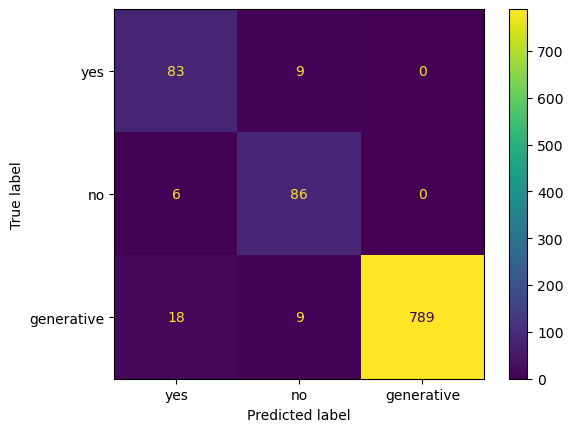

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results["train"][0]["yng_label"], results["train"][0]["pred_yng_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["yes", "no", "generative"])
disp.plot()
plt.show()

In [30]:
if 'tokenizer' not in locals() or 'model' not in locals():
    tokenizer, model = make_model(hyperparameters)
    model.load_state_dict(torch.load("checkpoints/bert_tiny_42_nh.pt"))

set_size = 100
if 'train_set' not in locals(): train_set = datasets.load_from_disk(CONFIG.dataset.processed_dir, )["train"].shuffle(42)
if 'val_set' not in locals(): val_set = datasets.load_from_disk(CONFIG.dataset.processed_dir)["validation"].shuffle(42)
if 'test_set' not in locals(): test_set = datasets.load_from_disk(CONFIG.dataset.processed_dir)["test"].shuffle(42)

if set_size is not None:
    train_set = train_set.select(range(set_size))
    val_set = val_set.select(range(set_size))
    test_set = test_set.select(range(set_size))

results = evaluate(model, tokenizer, train_set, val_set, test_set, hyperparameters)

print()
for key, (data, res)in results.items():
    print(f"\033[1mEvaluating {key} set: \033[0m\n")

    print("Example of Q&A generated:")
    for i in range(5):
        print("Q:", data["question"][i])
        print("A_pred:", data["pred_answer"][i])
        print("A_true:", data["answer"][i])
        print()

    tot_squad_f1 = res.pop("tot_squad_f1")

    print(f"Total {key} dataset SQUAD-f1: {tot_squad_f1[0]:.2f}")

    for k,v in res.items():
        print(f" - {k} = {v[0]:.2f} ({v[1]:.1f} %)")

    print("_"*30)
    print()

eval  train


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

/home/matteo/miniconda3/envs/nlp/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matteo/miniconda3/envs/nlp/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


eval  val


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

eval  test


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]


Evaluating train set: 

Example of Q&A generated:
Q: How did they greet?
A_pred: a tree
A_true: The two men shook hands

Q: what?
A_pred: she started
A_true: gloves

Q: Are they proud?
A_pred: yes
A_true: Yes

Q: How many terms did he serve?
A_pred: two
A_true: Three

Q: What was her opponent ranked?
A_pred: two
A_true: Fourth

Total train dataset SQUAD-f1: 0.08
 - yes_ans_f1 = 1.00 (6.0 %)
 - no_ans_f1 = 0.00 (4.0 %)
 - mc_quest_f1 = nan (0.0 %)
 - wh_quest_f1 = 0.01 (81.0 %)
______________________________

Evaluating val set: 

Example of Q&A generated:
Q: How often?
A_pred: five
A_true: each month

Q: How?
A_pred: a summer
A_true: swim across

Q: Who will decide the outcome of the election?
A_pred: president
A_true: the public

Q: With what?
A_pred: two
A_true: With the pontoon train

Q: How does Horn feel about the plan?
A_pred: a boat
A_true: It concerns him

Total val dataset SQUAD-f1: 0.08
 - yes_ans_f1 = 1.00 (7.0 %)
 - no_ans_f1 = 0.00 (8.0 %)
 - mc_quest_f1 = nan (0.0 %)
 - 

In [47]:
if 'tokenizer' not in locals() or 'model' not in locals():
    tokenizer, model = make_model(hyperparameters)
    model.load_state_dict(torch.load("checkpoints/bert_tiny_42_nh.pt"))

if 'dataset' not in locals(): dataset = datasets.load_from_disk(CONFIG.dataset.filtered_dir).shuffle(42)

df_test = pd.DataFrame(dataset["test"]).iloc[:10]

for source, df in df_test.groupby(by=['source']):
    conversations_results = pd.DataFrame(evaluate_conversation(model, tokenizer, df))
    conversations_results = conversations_results.sort_values(by='conversation_f1_score', ascending=True, inplace=False).iloc[:5, :].reset_index(drop=True)
    # print(conversations_results)
    for i in range(len(conversations_results)):
        print_conversation(conversations_results["passage"][i], conversations_results["questions"][i], conversations_results["answers"][i],
                            conversations_results["predicted_answers"][i], conversations_results["answers_f1_scores"][i],
                            conversations_results["conversation_f1_score"][i])
        raise

Passage: Los Angeles (CNN) -- A man convicted of stalking singer Madonna, and who once threatened to knife her, was arrested Friday, a week after he escaped from a Southern California mental hospital, police said. 

Robert Dewey Hoskins, 54, had walked away from Metropolitan State Hospital in the Los Angeles suburb of Norwalk on February 3, police said. 

He had served a 10-year prison sentence for stalking the "Material Girl," police said, and a court order requires him to be in a facility receiving mental health treatment until the end of August 2012. 

Los Angeles Police Sgt. Mitzi Fierro told HLN's Nancy Grace that she hadn't been told whether any new charges will be filed against Hoskins. 

"At this point they are returning him to the facility, and I believe that will be determined by the detectives who will investigate -- number one, his ability to walk away from the facility and, number two, if he violated anything from that point on," Fierro said. 

The facility he was in is no

RuntimeError: No active exception to reraise